# **BUSINESS CASE 2: SIEMENS ADVANTA SALES FORECASTING**  


## 🎓 Master’s Program in Data Science & Advanced Analytics 
**Nova IMS** | March 2025   
**Course:** Business Cases with Data Science

## 👥 Team **Group A**  
- **Alice Viegas** | 20240572  
- **Bernardo Faria** | 20240579  
- **Dinis Pinto** | 20240612  
- **Daan van Holten** | 20240681
- **Philippe Dutranoit** | 20240518

## 📊 Goal of the notebook

in this notebook we make the build and test the models for forcasting

# Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import itertools
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from prophet import Prophet


from Model_Functions import *

import importlib
imported_module = importlib.import_module("Model_Functions")
importlib.reload(imported_module)


<module 'Model_Functions' from '/Users/philippedutranoit/document_ordi/nova/business_case_for_data_sciense/cases/BC_DA_Siemens/Notebooks/Model_Functions.py'>

In [3]:
sales_agg1 = pd.read_csv('../data/sales_agg1.csv').set_index('DATE')
sales_agg3 = pd.read_csv('../data/sales_agg3.csv').set_index('DATE')
sales_agg4 = pd.read_csv('../data/sales_agg4.csv').set_index('DATE')
sales_agg5 = pd.read_csv('../data/sales_agg5.csv').set_index('DATE')
sales_agg6 = pd.read_csv('../data/sales_agg6.csv').set_index('DATE')
sales_agg8 = pd.read_csv('../data/sales_agg8.csv').set_index('DATE')
sales_agg9 = pd.read_csv('../data/sales_agg9.csv').set_index('DATE')
sales_agg11 = pd.read_csv('../data/sales_agg11.csv').set_index('DATE')
sales_agg12 = pd.read_csv('../data/sales_agg12.csv').set_index('DATE')
sales_agg13 = pd.read_csv('../data/sales_agg13.csv').set_index('DATE')
sales_agg14 = pd.read_csv('../data/sales_agg14.csv').set_index('DATE')
sales_agg16 = pd.read_csv('../data/sales_agg16.csv').set_index('DATE')
sales_agg20 = pd.read_csv('../data/sales_agg20.csv').set_index('DATE')
sales_agg36 = pd.read_csv('../data/sales_agg36.csv').set_index('DATE')

# extract the selected features list build in the feature selection step
selected_features_1 = pd.read_csv('../data/selected_features_1.csv')['selected_features'].tolist()
selected_features_3 = pd.read_csv('../data/selected_features_3.csv')['selected_features'].tolist()
selected_features_4 = pd.read_csv('../data/selected_features_4.csv')['selected_features'].tolist()
selected_features_5 = pd.read_csv('../data/selected_features_5.csv')['selected_features'].tolist()
selected_features_6 = pd.read_csv('../data/selected_features_6.csv')['selected_features'].tolist()
selected_features_8 = pd.read_csv('../data/selected_features_8.csv')['selected_features'].tolist()
selected_features_9 = pd.read_csv('../data/selected_features_9.csv')['selected_features'].tolist()
selected_features_11 = pd.read_csv('../data/selected_features_11.csv')['selected_features'].tolist()
selected_features_12 = pd.read_csv('../data/selected_features_12.csv')['selected_features'].tolist()
selected_features_13 = pd.read_csv('../data/selected_features_13.csv')['selected_features'].tolist()
selected_features_14 = pd.read_csv('../data/selected_features_14.csv')['selected_features'].tolist()
selected_features_16 = pd.read_csv('../data/selected_features_16.csv')['selected_features'].tolist()
selected_features_20 = pd.read_csv('../data/selected_features_20.csv')['selected_features'].tolist()
selected_features_36 = pd.read_csv('../data/selected_features_36.csv')['selected_features'].tolist()


# load the market data
df_market = pd.read_csv('../data/Market_data_predicted.csv').set_index('date')
test_set = pd.read_csv('../Data/Case2_Test Set Template.csv', sep=';')
print(sales_agg1.head())
df_market.head()



               Sales_EUR
DATE                    
2018-10-01  3.609892e+07
2018-11-01  3.699427e+07
2018-12-01  3.788961e+07
2019-01-01  2.772815e+07
2019-02-01  3.479316e+07


,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_SHP250,MAB_ELE_PRO392,MAB_ELE_SHP392,MAB_ELE_PRO756,MAB_ELE_SHP756,MAB_ELE_PRO826,MAB_ELE_SHP826,MAB_ELE_SHP840,...,PRI27380_org,PRI27250_org,PRI27276_org,PRO28756_org,PRO28392_org,PRO271000_org,PRO27756_org,PRO27826_org,PRO27392_org,PRO27276_org
date,,,,,,,,,,,,,,,,,,,,,
2004-02-01,16.940704,16.940704,83.458866,109.334010,110.495272,86.074496,80.962532,111.353812,77.766367,90.442749,...,93.020027,96.864647,93.230453,96.177481,110.890034,91.390440,68.677657,120.706516,106.161262,85.913200
2004-03-01,23.711852,23.711852,106.168192,140.884616,144.686166,86.038258,80.912352,127.558608,77.829225,90.580357,...,93.540268,96.864653,93.335678,96.250927,141.176853,91.511498,68.452548,138.309550,140.288741,97.670815
2004-04-01,24.435235,24.435235,92.007646,105.853579,102.655769,85.997063,80.857863,108.732297,77.904642,90.751805,...,93.852425,96.864659,93.440903,96.330211,105.648765,91.666790,68.203892,115.557330,106.271197,87.253983
2004-05-01,23.708115,23.708115,85.696486,101.864777,100.305285,85.951483,80.800601,110.645200,77.993606,90.961426,...,93.852425,96.864666,93.546127,96.413549,101.990361,91.861457,67.936322,119.269534,101.608710,84.675552
2004-06-01,27.009138,27.009138,106.641482,120.332920,119.616380,85.902640,80.742724,122.020960,78.096995,91.213203,...,93.956467,96.864672,93.440903,96.499291,122.136575,92.100289,67.655734,128.849416,116.655248,95.401802


In [4]:
test_set

,Month Year,Mapped_GCK,Sales_EUR
0,Mai 22,#3,NaN
1,Jun 22,#3,NaN
2,Jul 22,#3,NaN
3,Aug 22,#3,NaN
4,Sep 22,#3,NaN
...,...,...,...
135,Okt 22,#1,NaN
136,Nov 22,#1,NaN
137,Dez 22,#1,NaN
138,Jan 23,#1,NaN


In [5]:
month_map = {
    "Jan": 1,
    "Feb": 2,
    "Mai": 3,
    "Jun": 6,
    "Jul": 7,
    "Aug": 8,
    "Sep": 9,
    "Okt": 10,
    "Nov": 11,
    "Dez": 12
}

# Apply conversion safely
test_set['Month Year'] = test_set['Month Year'].apply(parse_month_year)

# Preparation 

## Create the lag market data feature needed for the model

In [6]:
df_market = create_lag_features(df_market, 6)
df_market.head()

/Users/philippedutranoit/document_ordi/nova/business_case_for_data_sciense/cases/BC_DA_Siemens/Notebooks/Model_Functions.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lagging[f'{col}_lag_{lag}'] = df_lagging[col].shift(lag)
/Users/philippedutranoit/document_ordi/nova/business_case_for_data_sciense/cases/BC_DA_Siemens/Notebooks/Model_Functions.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lagging[f'{col}_lag_{lag}'] = df_lagging[col].shift(lag)
/Users/philippedutranoit/document_ordi/nova/business_case_for_data

,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_SHP250,MAB_ELE_PRO392,MAB_ELE_SHP392,MAB_ELE_PRO756,MAB_ELE_SHP756,MAB_ELE_PRO826,MAB_ELE_SHP826,MAB_ELE_SHP840,...,PRI27380_org_lag_6,PRI27250_org_lag_6,PRI27276_org_lag_6,PRO28756_org_lag_6,PRO28392_org_lag_6,PRO271000_org_lag_6,PRO27756_org_lag_6,PRO27826_org_lag_6,PRO27392_org_lag_6,PRO27276_org_lag_6
date,,,,,,,,,,,,,,,,,,,,,
2004-02-01,16.940704,16.940704,83.458866,109.334010,110.495272,86.074496,80.962532,111.353812,77.766367,90.442749,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-01,23.711852,23.711852,106.168192,140.884616,144.686166,86.038258,80.912352,127.558608,77.829225,90.580357,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-04-01,24.435235,24.435235,92.007646,105.853579,102.655769,85.997063,80.857863,108.732297,77.904642,90.751805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-05-01,23.708115,23.708115,85.696486,101.864777,100.305285,85.951483,80.800601,110.645200,77.993606,90.961426,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-06-01,27.009138,27.009138,106.641482,120.332920,119.616380,85.902640,80.742724,122.020960,78.096995,91.213203,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Created lagged sales features needed for the model

In [7]:
sales_agg1

,Sales_EUR
DATE,
2018-10-01,3.609892e+07
2018-11-01,3.699427e+07
2018-12-01,3.788961e+07
2019-01-01,2.772815e+07
2019-02-01,3.479316e+07
2019-03-01,3.385680e+07
2019-04-01,3.968829e+07
2019-05-01,3.889797e+07
2019-06-01,3.910675e+07


In [8]:
#sales_agg_with_lag1 = create_lag_features(sales_agg1, 10)
sales_agg_with_lag3 = create_lag_features(sales_agg3, 10)
sales_agg_with_lag4 = create_lag_features(sales_agg4, 10)
sales_agg_with_lag5 = create_lag_features(sales_agg5, 10)
sales_agg_with_lag6 = create_lag_features(sales_agg6, 10)
sales_agg_with_lag8 = create_lag_features(sales_agg8, 10)
sales_agg_with_lag9 = create_lag_features(sales_agg9, 10)
sales_agg_with_lag11 = create_lag_features(sales_agg11, 10)
sales_agg_with_lag12 = create_lag_features(sales_agg12, 10)
sales_agg_with_lag13 = create_lag_features(sales_agg13, 10)
sales_agg_with_lag14 = create_lag_features(sales_agg14, 10)
sales_agg_with_lag16 = create_lag_features(sales_agg16, 10)
sales_agg_with_lag20 = create_lag_features(sales_agg20, 10)
sales_agg_with_lag36 = create_lag_features(sales_agg36, 10)

In [9]:
sales_agg1

,Sales_EUR
DATE,
2018-10-01,3.609892e+07
2018-11-01,3.699427e+07
2018-12-01,3.788961e+07
2019-01-01,2.772815e+07
2019-02-01,3.479316e+07
2019-03-01,3.385680e+07
2019-04-01,3.968829e+07
2019-05-01,3.889797e+07
2019-06-01,3.910675e+07


## Define the parameter grid to run

In [10]:
xgboost_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7, 1],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.1, 0.3],
    'reg_lambda': [0, 0.1, 0.3]
}

prophet_param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'yearly_seasonality': [True, False],
    'weekly_seasonality': [True, False],
    'daily_seasonality': [True, False],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'changepoint_prior_scale': [0.01, 0.1, 0.5]
}

# Product 1

In [11]:
# selecte only the features that are selected in the feature selection step
test_set_1 = test_set[test_set['Mapped_GCK'] == '#1']
df_market_1 = df_market[selected_features_1]
df_market_1.head()

,PRO27826_org_lag_1,PRO27826_org,MAB_ELE_PRO756_lag_1,PRI27380_org,PRO271000_org_lag_5,PRO27392_org_lag_3,PRO28392_org_lag_6
date,,,,,,,
2004-02-01,NaN,120.706516,NaN,93.020027,NaN,NaN,NaN
2004-03-01,120.706516,138.309550,86.074496,93.540268,NaN,NaN,NaN
2004-04-01,138.309550,115.557330,86.038258,93.852425,NaN,NaN,NaN
2004-05-01,115.557330,119.269534,85.997063,93.852425,NaN,106.161262,NaN
2004-06-01,119.269534,128.849416,85.951483,93.956467,NaN,140.288741,NaN


## Xgboost

In [12]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg1, df_market_1, train_size = 0.8)

X_val.info() 

xgboost_best_model_1, xgboost_best_params_1, xgboost_best_rmse_1 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_1)
print("Validation RMSE:", xgboost_best_rmse_1)



<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2021-08-01 to 2022-04-01
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PRO27826_org_lag_1    9 non-null      float64
 1   PRO27826_org          9 non-null      float64
 2   MAB_ELE_PRO756_lag_1  9 non-null      float64
 3   PRI27380_org          9 non-null      float64
 4   PRO271000_org_lag_5   9 non-null      float64
 5   PRO27392_org_lag_3    9 non-null      float64
 6   PRO28392_org_lag_6    9 non-null      float64
dtypes: float64(7)
memory usage: 576.0+ bytes
Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0} => RMSE: 3139955.7876
Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0.1} => RMSE: 3161485.3536
Params: {'n_estimators

## Prophet

In [13]:
prophet_best_model_1, prophet_best_params_1, prophet_best_rmse_1 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_1)

print("Validation RMSE:", prophet_best_rmse_1)

17:09:23 - cmdstanpy - INFO - Chain [1] start processing
17:09:23 - cmdstanpy - INFO - Chain [1] done processing
17:09:23 - cmdstanpy - INFO - Chain [1] start processing
17:09:23 - cmdstanpy - INFO - Chain [1] done processing
17:09:23 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 5503348.8019
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 10118173.9628


17:09:24 - cmdstanpy - INFO - Chain [1] done processing
17:09:24 - cmdstanpy - INFO - Chain [1] start processing
17:09:24 - cmdstanpy - INFO - Chain [1] done processing
17:09:24 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 14585959.4522
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 17834572.8573


17:09:38 - cmdstanpy - INFO - Chain [1] done processing
17:09:38 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 42617755.7143


17:09:51 - cmdstanpy - INFO - Chain [1] done processing
17:09:51 - cmdstanpy - INFO - Chain [1] start processing
17:09:51 - cmdstanpy - INFO - Chain [1] done processing
17:09:52 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 39983941.2010
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 16756310.2723


17:10:03 - cmdstanpy - INFO - Chain [1] done processing
17:10:03 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 48628394.2484


17:10:17 - cmdstanpy - INFO - Chain [1] done processing
17:10:17 - cmdstanpy - INFO - Chain [1] start processing
17:10:17 - cmdstanpy - INFO - Chain [1] done processing
17:10:17 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 55715776.5224
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 5587228.6736


17:10:17 - cmdstanpy - INFO - Chain [1] done processing
17:10:17 - cmdstanpy - INFO - Chain [1] start processing
17:10:17 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 10109295.7400


17:10:17 - cmdstanpy - INFO - Chain [1] start processing
17:10:17 - cmdstanpy - INFO - Chain [1] done processing
17:10:17 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 14582884.2409
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 17801528.0934


17:10:29 - cmdstanpy - INFO - Chain [1] done processing
17:10:29 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 48968079.8583


17:10:41 - cmdstanpy - INFO - Chain [1] done processing
17:10:41 - cmdstanpy - INFO - Chain [1] start processing
17:10:41 - cmdstanpy - INFO - Chain [1] done processing
17:10:41 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 37037651.0248
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 16558112.6375


17:10:52 - cmdstanpy - INFO - Chain [1] done processing
17:10:52 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 45811121.9210


17:11:04 - cmdstanpy - INFO - Chain [1] done processing
17:11:04 - cmdstanpy - INFO - Chain [1] start processing
17:11:04 - cmdstanpy - INFO - Chain [1] done processing
17:11:04 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 68712759.7089
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 3787710.5697


17:11:04 - cmdstanpy - INFO - Chain [1] done processing
17:11:04 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 3787384.5013


17:11:04 - cmdstanpy - INFO - Chain [1] done processing
17:11:04 - cmdstanpy - INFO - Chain [1] start processing
17:11:04 - cmdstanpy - INFO - Chain [1] done processing
17:11:05 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 3682155.5436
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 8057011.6086


17:11:05 - cmdstanpy - INFO - Chain [1] done processing
17:11:05 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 7692347.1117


17:11:05 - cmdstanpy - INFO - Chain [1] done processing
17:11:05 - cmdstanpy - INFO - Chain [1] start processing
17:11:05 - cmdstanpy - INFO - Chain [1] done processing
17:11:05 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 9532713.2895
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 8283645.5582


17:11:05 - cmdstanpy - INFO - Chain [1] done processing
17:11:05 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 7890956.8735


17:11:06 - cmdstanpy - INFO - Chain [1] done processing
17:11:06 - cmdstanpy - INFO - Chain [1] start processing
17:11:06 - cmdstanpy - INFO - Chain [1] done processing
17:11:06 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 9728433.1384
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 3787641.9395


17:11:06 - cmdstanpy - INFO - Chain [1] done processing
17:11:06 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 3789570.6226


17:11:06 - cmdstanpy - INFO - Chain [1] done processing
17:11:06 - cmdstanpy - INFO - Chain [1] start processing
17:11:06 - cmdstanpy - INFO - Chain [1] done processing
17:11:06 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 3681982.2410
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 8032357.9068


17:11:06 - cmdstanpy - INFO - Chain [1] done processing
17:11:06 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 8405306.7856


17:11:07 - cmdstanpy - INFO - Chain [1] done processing
17:11:07 - cmdstanpy - INFO - Chain [1] start processing
17:11:07 - cmdstanpy - INFO - Chain [1] done processing
17:11:07 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 9543803.0328
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 8355816.4945


17:11:07 - cmdstanpy - INFO - Chain [1] done processing
17:11:07 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 8566558.6171


17:11:07 - cmdstanpy - INFO - Chain [1] done processing
17:11:07 - cmdstanpy - INFO - Chain [1] start processing
17:11:07 - cmdstanpy - INFO - Chain [1] done processing
17:11:07 - cmdstanpy - INFO - Chain [1] start processing
17:11:07 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 9886883.0904
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 4114839.9213
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 4114734.4753


17:11:07 - cmdstanpy - INFO - Chain [1] start processing
17:11:07 - cmdstanpy - INFO - Chain [1] done processing
17:11:07 - cmdstanpy - INFO - Chain [1] start processing
17:11:08 - cmdstanpy - INFO - Chain [1] done processing
17:11:08 - cmdstanpy - INFO - Chain [1] start processing
17:11:08 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 4335936.2044
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 4054388.3461


17:11:08 - cmdstanpy - INFO - Chain [1] start processing
17:11:08 - cmdstanpy - INFO - Chain [1] done processing
17:11:08 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 4157154.4672
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 4355096.4193


17:11:08 - cmdstanpy - INFO - Chain [1] done processing
17:11:08 - cmdstanpy - INFO - Chain [1] start processing
17:11:08 - cmdstanpy - INFO - Chain [1] done processing
17:11:08 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 4097154.5129
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 4158550.8677


17:11:08 - cmdstanpy - INFO - Chain [1] done processing
17:11:08 - cmdstanpy - INFO - Chain [1] start processing
17:11:08 - cmdstanpy - INFO - Chain [1] done processing
17:11:08 - cmdstanpy - INFO - Chain [1] start processing
17:11:09 - cmdstanpy - INFO - Chain [1] done processing
17:11:09 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 4354653.3870
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 4114837.4124
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 4114556.8089


17:11:09 - cmdstanpy - INFO - Chain [1] done processing
17:11:09 - cmdstanpy - INFO - Chain [1] start processing
17:11:09 - cmdstanpy - INFO - Chain [1] done processing
17:11:09 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 4331429.8657
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 4033253.2643


17:11:09 - cmdstanpy - INFO - Chain [1] done processing
17:11:09 - cmdstanpy - INFO - Chain [1] start processing
17:11:09 - cmdstanpy - INFO - Chain [1] done processing
17:11:09 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 4141162.7109
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 4355845.4438


17:11:09 - cmdstanpy - INFO - Chain [1] done processing
17:11:09 - cmdstanpy - INFO - Chain [1] start processing
17:11:09 - cmdstanpy - INFO - Chain [1] done processing
17:11:09 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 4088668.9442
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 4128217.7928


17:11:10 - cmdstanpy - INFO - Chain [1] done processing
17:11:10 - cmdstanpy - INFO - Chain [1] start processing
17:11:10 - cmdstanpy - INFO - Chain [1] done processing
17:11:10 - cmdstanpy - INFO - Chain [1] start processing
17:11:10 - cmdstanpy - INFO - Chain [1] done processing
17:11:10 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 4357342.3532
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 3689104.1436
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 3698558.5571


17:11:10 - cmdstanpy - INFO - Chain [1] done processing
17:11:10 - cmdstanpy - INFO - Chain [1] start processing
17:11:10 - cmdstanpy - INFO - Chain [1] done processing
17:11:10 - cmdstanpy - INFO - Chain [1] start processing
17:11:10 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 3670820.0652
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 3688992.3837


17:11:10 - cmdstanpy - INFO - Chain [1] start processing
17:11:10 - cmdstanpy - INFO - Chain [1] done processing
17:11:10 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 3698636.8288
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 3670185.5296


17:11:10 - cmdstanpy - INFO - Chain [1] done processing
17:11:10 - cmdstanpy - INFO - Chain [1] start processing
17:11:11 - cmdstanpy - INFO - Chain [1] done processing
17:11:11 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 3700221.9203
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 3703571.6497


17:11:11 - cmdstanpy - INFO - Chain [1] done processing
17:11:11 - cmdstanpy - INFO - Chain [1] start processing
17:11:11 - cmdstanpy - INFO - Chain [1] done processing
17:11:11 - cmdstanpy - INFO - Chain [1] start processing
17:11:11 - cmdstanpy - INFO - Chain [1] done processing
17:11:11 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 3670053.3696
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 3689102.8841
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 3697621.0274


17:11:11 - cmdstanpy - INFO - Chain [1] done processing
17:11:11 - cmdstanpy - INFO - Chain [1] start processing
17:11:11 - cmdstanpy - INFO - Chain [1] done processing
17:11:11 - cmdstanpy - INFO - Chain [1] start processing
17:11:11 - cmdstanpy - INFO - Chain [1] done processing
17:11:11 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 3669936.6345
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 3689102.8841
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 3697621.0274


17:11:11 - cmdstanpy - INFO - Chain [1] done processing
17:11:11 - cmdstanpy - INFO - Chain [1] start processing
17:11:11 - cmdstanpy - INFO - Chain [1] done processing
17:11:11 - cmdstanpy - INFO - Chain [1] start processing
17:11:11 - cmdstanpy - INFO - Chain [1] done processing
17:11:11 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 3669936.6345
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 3689102.8841
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 3697621.0274


17:11:12 - cmdstanpy - INFO - Chain [1] done processing
17:11:12 - cmdstanpy - INFO - Chain [1] start processing
17:11:12 - cmdstanpy - INFO - Chain [1] done processing
17:11:12 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 3669936.6345
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 5841316.7623


17:11:12 - cmdstanpy - INFO - Chain [1] done processing
17:11:12 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 7789618.3984


17:11:26 - cmdstanpy - INFO - Chain [1] done processing
17:11:26 - cmdstanpy - INFO - Chain [1] start processing
17:11:26 - cmdstanpy - INFO - Chain [1] done processing
17:11:26 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 39450102.0490
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 17422697.5113


17:11:41 - cmdstanpy - INFO - Chain [1] done processing
17:11:41 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 51347156.6878


17:11:55 - cmdstanpy - INFO - Chain [1] done processing
17:11:55 - cmdstanpy - INFO - Chain [1] start processing
17:11:55 - cmdstanpy - INFO - Chain [1] done processing
17:11:55 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 55990228.8769
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 17116808.9911


17:12:09 - cmdstanpy - INFO - Chain [1] done processing
17:12:09 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 53137652.4297


17:12:23 - cmdstanpy - INFO - Chain [1] done processing
17:12:23 - cmdstanpy - INFO - Chain [1] start processing
17:12:23 - cmdstanpy - INFO - Chain [1] done processing
17:12:23 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 57560279.9345
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 5469356.5416


17:12:23 - cmdstanpy - INFO - Chain [1] done processing
17:12:23 - cmdstanpy - INFO - Chain [1] start processing
17:12:23 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 7977471.9518
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 10485449.6173


17:12:23 - cmdstanpy - INFO - Chain [1] start processing
17:12:23 - cmdstanpy - INFO - Chain [1] done processing
17:12:23 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 18132434.2306


17:12:36 - cmdstanpy - INFO - Chain [1] done processing
17:12:36 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 53707610.4314


17:12:48 - cmdstanpy - INFO - Chain [1] done processing
17:12:48 - cmdstanpy - INFO - Chain [1] start processing
17:12:48 - cmdstanpy - INFO - Chain [1] done processing
17:12:48 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 48661728.0999
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 17131215.0142


17:13:00 - cmdstanpy - INFO - Chain [1] done processing
17:13:00 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 55306283.1133


17:13:11 - cmdstanpy - INFO - Chain [1] done processing
17:13:11 - cmdstanpy - INFO - Chain [1] start processing
17:13:12 - cmdstanpy - INFO - Chain [1] done processing
17:13:12 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 54003582.3743
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 3789578.4216


17:13:12 - cmdstanpy - INFO - Chain [1] done processing
17:13:12 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 3795284.9156


17:13:12 - cmdstanpy - INFO - Chain [1] done processing
17:13:12 - cmdstanpy - INFO - Chain [1] start processing
17:13:12 - cmdstanpy - INFO - Chain [1] done processing
17:13:12 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 3867574.5772
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 8174645.5164


17:13:12 - cmdstanpy - INFO - Chain [1] done processing
17:13:12 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 8754931.0134


17:13:25 - cmdstanpy - INFO - Chain [1] done processing
17:13:25 - cmdstanpy - INFO - Chain [1] start processing
17:13:25 - cmdstanpy - INFO - Chain [1] done processing
17:13:25 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 4767698.6688
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 8453335.6246


17:13:37 - cmdstanpy - INFO - Chain [1] done processing
17:13:37 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 8554713.3896


17:13:50 - cmdstanpy - INFO - Chain [1] done processing
17:13:50 - cmdstanpy - INFO - Chain [1] start processing
17:13:50 - cmdstanpy - INFO - Chain [1] done processing
17:13:50 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 5597710.1049
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 3684744.4937


17:13:50 - cmdstanpy - INFO - Chain [1] done processing
17:13:50 - cmdstanpy - INFO - Chain [1] start processing
17:13:50 - cmdstanpy - INFO - Chain [1] done processing
17:13:50 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 3681532.1269
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 3607775.0477


17:13:50 - cmdstanpy - INFO - Chain [1] done processing
17:13:50 - cmdstanpy - INFO - Chain [1] start processing
17:13:50 - cmdstanpy - INFO - Chain [1] done processing
17:13:50 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 8001598.0331
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 9024136.6634


17:13:51 - cmdstanpy - INFO - Chain [1] done processing
17:13:51 - cmdstanpy - INFO - Chain [1] start processing
17:13:51 - cmdstanpy - INFO - Chain [1] done processing
17:13:51 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 10583075.8762
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 8254398.5198


17:13:51 - cmdstanpy - INFO - Chain [1] done processing
17:13:51 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 8542672.0486


17:13:51 - cmdstanpy - INFO - Chain [1] done processing
17:13:51 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 10891279.0519


17:13:51 - cmdstanpy - INFO - Chain [1] done processing
17:13:52 - cmdstanpy - INFO - Chain [1] start processing
17:13:52 - cmdstanpy - INFO - Chain [1] done processing
17:13:52 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 4001016.8600
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 4043114.9092


17:13:52 - cmdstanpy - INFO - Chain [1] done processing
17:13:52 - cmdstanpy - INFO - Chain [1] start processing
17:13:52 - cmdstanpy - INFO - Chain [1] done processing
17:13:52 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 4231788.4106
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 3997836.6221


17:13:52 - cmdstanpy - INFO - Chain [1] done processing
17:13:52 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 4070528.2755


17:13:52 - cmdstanpy - INFO - Chain [1] done processing
17:13:53 - cmdstanpy - INFO - Chain [1] start processing
17:13:53 - cmdstanpy - INFO - Chain [1] done processing
17:13:53 - cmdstanpy - INFO - Chain [1] start processing
17:13:53 - cmdstanpy - INFO - Chain [1] done processing
17:13:53 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 3922568.5705
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 4081269.5130
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 4074304.7992


17:13:53 - cmdstanpy - INFO - Chain [1] done processing
17:13:53 - cmdstanpy - INFO - Chain [1] start processing
17:13:53 - cmdstanpy - INFO - Chain [1] done processing
17:13:53 - cmdstanpy - INFO - Chain [1] start processing
17:13:53 - cmdstanpy - INFO - Chain [1] done processing
17:13:53 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 9076969.6789
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 4047243.4286
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 4036535.4908


17:13:53 - cmdstanpy - INFO - Chain [1] done processing
17:13:53 - cmdstanpy - INFO - Chain [1] start processing
17:13:53 - cmdstanpy - INFO - Chain [1] done processing
17:13:54 - cmdstanpy - INFO - Chain [1] start processing
17:13:54 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 4227560.4351
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 4067187.8862
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 4066757.3566


17:13:54 - cmdstanpy - INFO - Chain [1] start processing
17:13:54 - cmdstanpy - INFO - Chain [1] done processing
17:13:54 - cmdstanpy - INFO - Chain [1] start processing
17:13:54 - cmdstanpy - INFO - Chain [1] done processing
17:13:54 - cmdstanpy - INFO - Chain [1] start processing
17:13:54 - cmdstanpy - INFO - Chain [1] done processing
17:13:54 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 4212299.8372
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 4067296.0591
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 4072332.8854


17:13:54 - cmdstanpy - INFO - Chain [1] done processing
17:13:54 - cmdstanpy - INFO - Chain [1] start processing
17:13:54 - cmdstanpy - INFO - Chain [1] done processing
17:13:54 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 4265524.0573
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 3728069.8658


17:13:54 - cmdstanpy - INFO - Chain [1] done processing
17:13:54 - cmdstanpy - INFO - Chain [1] start processing
17:13:54 - cmdstanpy - INFO - Chain [1] done processing
17:13:55 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 3705900.1783
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 3656788.3159


17:13:55 - cmdstanpy - INFO - Chain [1] done processing
17:13:55 - cmdstanpy - INFO - Chain [1] start processing
17:13:55 - cmdstanpy - INFO - Chain [1] done processing
17:13:55 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 3671661.9633
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 3704101.7758


17:13:55 - cmdstanpy - INFO - Chain [1] done processing
17:13:55 - cmdstanpy - INFO - Chain [1] start processing
17:13:55 - cmdstanpy - INFO - Chain [1] done processing
17:13:55 - cmdstanpy - INFO - Chain [1] start processing
17:13:55 - cmdstanpy - INFO - Chain [1] done processing
17:13:55 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 3274042.5814
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 3754385.6601
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 3706528.1814


17:13:55 - cmdstanpy - INFO - Chain [1] done processing
17:13:55 - cmdstanpy - INFO - Chain [1] start processing
17:13:56 - cmdstanpy - INFO - Chain [1] done processing
17:13:56 - cmdstanpy - INFO - Chain [1] start processing
17:13:56 - cmdstanpy - INFO - Chain [1] done processing
17:13:56 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 3315835.4980
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 3689102.8841
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 3697621.0274


17:13:56 - cmdstanpy - INFO - Chain [1] done processing
17:13:56 - cmdstanpy - INFO - Chain [1] start processing
17:13:56 - cmdstanpy - INFO - Chain [1] done processing
17:13:56 - cmdstanpy - INFO - Chain [1] start processing
17:13:56 - cmdstanpy - INFO - Chain [1] done processing
17:13:56 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 3669936.6345
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 3689102.8841
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 3697621.0274


17:13:56 - cmdstanpy - INFO - Chain [1] done processing
17:13:56 - cmdstanpy - INFO - Chain [1] start processing
17:13:56 - cmdstanpy - INFO - Chain [1] done processing
17:13:56 - cmdstanpy - INFO - Chain [1] start processing
17:13:56 - cmdstanpy - INFO - Chain [1] done processing
17:13:56 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 3669936.6345
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 3689102.8841
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 3697621.0274


17:13:56 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 3669936.6345
Best Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5}
Validation RMSE: 3274042.581357753


## Final prediction

In [14]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_1, prophet_best_params_1, prophet_best_rmse_1, "Prophet",
    xgboost_best_model_1, xgboost_best_params_1, xgboost_best_rmse_1, "XGBoost"
)

print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

Best Model: XGBoost
Best Parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.5, 'colsample_bytree': 1, 'gamma': 0, 'reg_alpha': 0.3, 'reg_lambda': 0}
Best RMSE: 2381589.984644291


In [11]:
test_set_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 130 to 139
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month Year  10 non-null     object 
 1   Mapped_GCK  10 non-null     object 
 2   Sales_EUR   0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 320.0+ bytes


In [ ]:
def simple_prophet_forecast(sales_agg, df_market, param=None, period=10):
    # Rename columns for Prophet
    sales_agg = sales_agg.reset_index().rename(columns={"DATE": "ds", "Sales_EUR": "y"})
    df_market = df_market.reset_index().rename(columns={"date": "ds"})

    # Ensure datetime format
    sales_agg["ds"] = pd.to_datetime(sales_agg["ds"])
    df_market["ds"] = pd.to_datetime(df_market["ds"])

    # Merge historical data with market data
    df_train = pd.merge(sales_agg, df_market, on="ds", how="inner")

    # Initialize Prophet
    model = Prophet(**param) if param else Prophet()

    # Add market regressors
    for col in df_market.columns:
        if col != "ds":
            model.add_regressor(col)

    # Fit model
    model.fit(df_train)

    # Prepare future dataframe (last 10 rows from df_market)
    df_future = df_market.sort_values("ds").tail(period).copy()

    # Predict
    forecast = model.predict(df_future)

    # Return only relevant columns
    results = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(sales_agg["ds"], sales_agg["y"], label="Historical Sales")
    plt.plot(results["ds"], results["yhat"], label="Forecast", color="red")
    plt.fill_between(results["ds"], results["yhat_lower"], results["yhat_upper"], color='red', alpha=0.2)
    plt.title("10-Month Sales Forecast with Prophet")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.grid(True)
    plt.show()

    return results


In [19]:
prophet_best_params_1 = {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5}

17:21:48 - cmdstanpy - INFO - Chain [1] start processing
17:21:48 - cmdstanpy - INFO - Chain [1] done processing


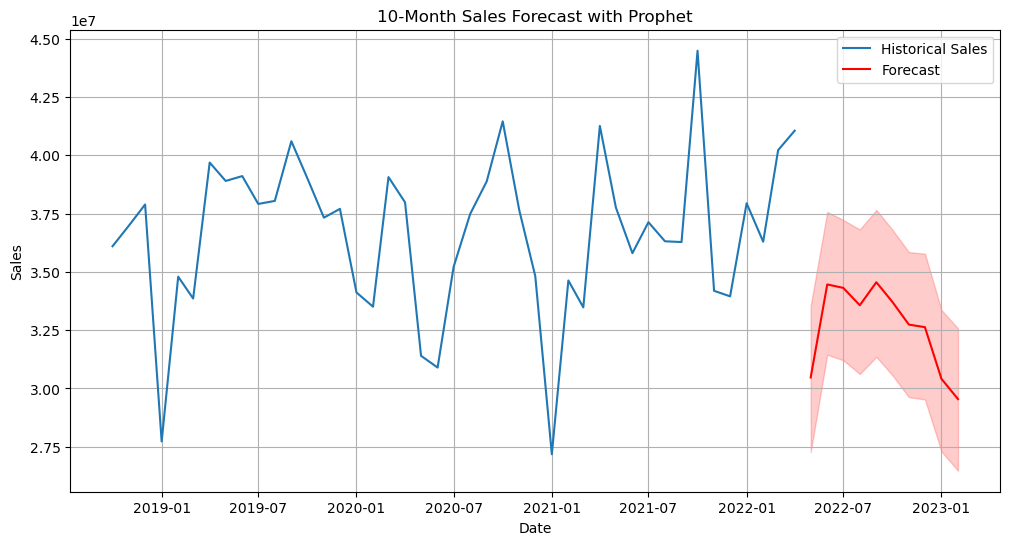

,ds,yhat,yhat_lower,yhat_upper
0,2022-05-01,3.047079e+07,2.727327e+07,3.355256e+07
1,2022-06-01,3.445993e+07,3.144916e+07,3.757010e+07
2,2022-07-01,3.431425e+07,3.121193e+07,3.722685e+07
3,2022-08-01,3.356746e+07,3.062064e+07,3.681688e+07
4,2022-09-01,3.455534e+07,3.135329e+07,3.765659e+07
5,2022-10-01,3.371410e+07,3.056934e+07,3.680988e+07
6,2022-11-01,3.273802e+07,2.962618e+07,3.584633e+07
7,2022-12-01,3.262855e+07,2.952937e+07,3.578042e+07
8,2023-01-01,3.041192e+07,2.729806e+07,3.336412e+07
9,2023-02-01,2.954448e+07,2.647243e+07,3.257336e+07


In [20]:
simple_prophet_forecast(sales_agg1, df_market_1, prophet_best_params_1, period=10)

In [ ]:
def simple_xgboost_forecast(sales_agg, df_market, period=10, params=None):
    # Prepare input data
    sales_agg = sales_agg.reset_index().rename(columns={"DATE": "ds", "Sales_EUR": "y"})
    df_market = df_market.reset_index().rename(columns={"date": "ds"})

    # Ensure datetime format
    sales_agg["ds"] = pd.to_datetime(sales_agg["ds"])
    df_market["ds"] = pd.to_datetime(df_market["ds"])

    # Merge to get training set
    df_train = pd.merge(sales_agg, df_market, on="ds", how="inner")

    # Define features and target
    feature_cols = [col for col in df_market.columns if col != "ds"]
    X_train = df_train[feature_cols]
    y_train = df_train["y"]

    # Train model
    model = xgb.XGBRegressor(**params) if params else xgb.XGBRegressor()
    model.fit(X_train, y_train)

    # Prepare future data: last `period` rows of df_market
    df_future = df_market.sort_values("ds").tail(period).copy()
    X_future = df_future[feature_cols]

    # Predict
    y_pred = model.predict(X_future)
    df_future["yhat"] = y_pred

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(sales_agg["ds"], sales_agg["y"], label="Historical Sales", color="blue")
    plt.plot(df_future["ds"], df_future["yhat"], label="Forecast", color="red")
    plt.title("10-Month Sales Forecast with XGBoost")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.grid(True)
    plt.show()

    return df_future[["ds", "yhat"]]


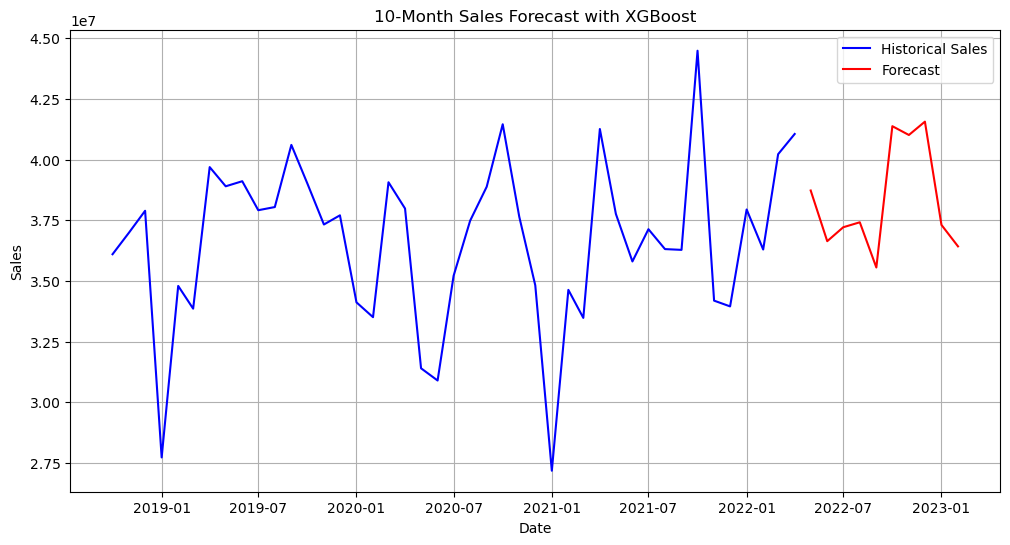

,ds,yhat
219,2022-05-01,38724736.0
220,2022-06-01,36636892.0
221,2022-07-01,37210896.0
222,2022-08-01,37415348.0
223,2022-09-01,35552632.0
224,2022-10-01,41373964.0
225,2022-11-01,41011636.0
226,2022-12-01,41561124.0
227,2023-01-01,37307848.0
228,2023-02-01,36422704.0


In [18]:
simple_xgboost_forecast(sales_agg1, df_market_1, period=10, params=xgboost_best_params_1)